In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import database as db
from datetime import timedelta

import anomaly_detection as ao

sns.set()

In [2]:
def run_anomalies(df, run_date, social_mod=None,
                  limit=95, horizon=12, simulations=10):   

    all_forcs = ao.anomaly_wrapper(df, run_date, horizon,
                                   simulations=simulations,
                                   social_mod=social_mod)

    forcs_df = (all_forcs.groupby(['region', 'cutoff', 'ds'])
                ['percent_ill']
                .describe(percentiles=[.025, 0.05, .1, .25, .5, .75, .9, .95, .975])
                .reset_index())

    # Be sure to grab the correct percentile...
    limit_dict = {90: '95%', 95: '97.5%'}

    forcs_df = forcs_df.merge(df[['region', 'percent_ill', 'ds']],
                              on=['region', 'ds'], how='outer')

    forcs_df['anomaly_diff'] = (forcs_df['percent_ill']
                                - forcs_df[limit_dict[limit]])
    forcs_df['anomaly_ili'] = np.where(forcs_df['anomaly_diff'] > 0,
                                       forcs_df['percent_ill'], np.nan)

    # Only keep the significant anomaly differences
    forcs_df['anomaly_diff'] = (forcs_df['anomaly_ili'] -
                                forcs_df[limit_dict[limit]])
    forcs_df['anomaly_diff'] = forcs_df['anomaly_diff'].fillna(0)
    
    return forcs_df


In [3]:
# Create the Brooklyn, NY ensemble forecasting and anomaly detection example...
bk_df = pd.read_csv('data/brooklyn.csv')
bk_df['ds'] = pd.to_datetime(bk_df['ds'])

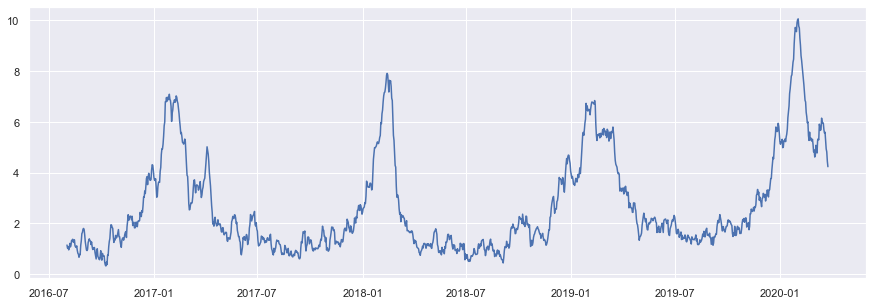

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(bk_df['ds'], bk_df['percent_ill'])

In [5]:
test = run_anomalies(bk_df, ['2020-03-01'], simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


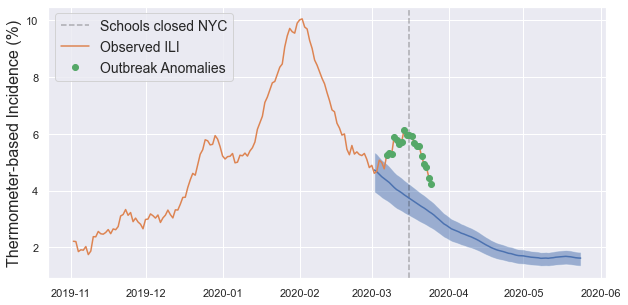

In [6]:
### Figure 2: Example detection in Brooklyn, NY
sub = test[test.ds > '2019-11-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Thermometer-based Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper left')
plt.savefig('Figure 2.png', dpi=300);

In [7]:
test_distancing = run_anomalies(bk_df, ['2020-03-01'], social_mod=0.85, simulations=100)

Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


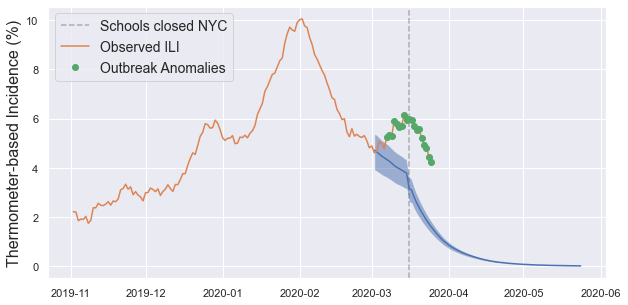

In [8]:
### Social distancing estimate
sub = test_distancing[test_distancing.ds > '2019-11-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Schools closed NYC')
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Thermometer-based Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper left')

In [9]:
## Now for the Santa Clara example
sc_df = pd.read_csv('data/santa_clara.csv')
sc_df['ds'] = pd.to_datetime(sc_df['ds'])

In [10]:
test = run_anomalies(sc_df, ['2020-03-01'], simulations=100)

Forecasting for 6085


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


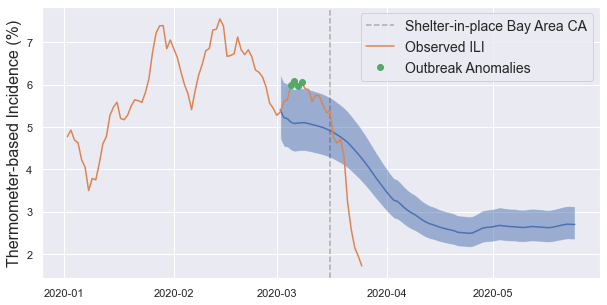

In [11]:
### Figure SX: Example detection in Santa Clara County
sub = test[test.ds > '2020-01-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area CA')
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Thermometer-based Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper right')

In [12]:
test_distancing = run_anomalies(sc_df, ['2020-03-01'], social_mod=0.85, simulations=100)

Forecasting for 6085


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


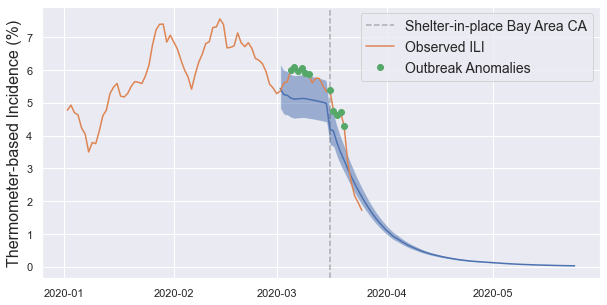

In [13]:
### Figure SX: Example detection in Santa Clara County w/ distancing
sub = test_distancing[test_distancing.ds > '2020-01-01'].copy()
sub.sort_values('ds', inplace=True)

plt.figure(figsize=(10, 5))
plt.axvline(pd.to_datetime('2020-03-16'), color='k', linestyle='--', alpha=0.3, label='Shelter-in-place Bay Area CA')
plt.fill_between(sub.ds, sub['97.5%'], sub['2.5%'], alpha=0.5)
plt.plot(sub.ds, sub['50%'], label='')
plt.plot(sub.ds, sub.percent_ill, label='Observed ILI')
plt.plot(sub.ds, sub.anomaly_ili, '.', ms=12, label='Outbreak Anomalies')

plt.ylabel('Thermometer-based Incidence (%)', fontsize=16)
plt.legend(fontsize=14, loc='upper right')

In [14]:
# Now, how does this effect our correlations to COVID cases?
# Well, in Brooklyn we don't have easily available counts, so we will run a sensitivity analysis
# across a range of reduced transmission rates to assess the impact on correlations
covid = pd.read_csv('data/timeseries-jhu.csv')

sc_covid = covid[(covid.county == 'Santa Clara County')]
sc_covid= sc_covid.drop(['lat', 'long', 'city', 'state', 'country', 'population', 'url'], axis=1)
sc_covid = sc_covid.melt(id_vars='county', var_name='ds', value_name='cases')
sc_covid['ds'] = pd.to_datetime(sc_covid.ds, format='%Y-%m-%d')
sc_covid = sc_covid[sc_covid.ds > '2020-03-01']

# complete COVID data from JHU is only available for the entire state
ny_covid = covid[(covid.state == 'NY') & (covid.county.isna()) & (covid.city.isna())]
ny_covid= ny_covid.drop(['lat', 'long', 'city', 'county', 'country', 'population', 'url'], axis=1)
ny_covid = ny_covid.melt(id_vars='state', var_name='ds', value_name='cases')
ny_covid['ds'] = pd.to_datetime(ny_covid.ds, format='%Y-%m-%d')
ny_covid = ny_covid[ny_covid.ds > '2020-03-01']

In [15]:
# Now, let's look at how the correlations between cumulative anomaly incidence
# and total COVID cases vary with distancing reductions in transmission
# look at reductions down to 25% below standard

dfs = []

for distance in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    print(f'Running distancing at {distance}')
    out = run_anomalies(bk_df, ['2020-03-01'], social_mod=distance, simulations=10)
    out['distancing'] = 1 - distance
    dfs.append(out)
    
bk_distancing = pd.concat(dfs, axis=0)

Running distancing at 1
Forecasting for 36047


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Running distancing at 0.95
Forecasting for 36047
Running distancing at 0.9
Forecasting for 36047
Running distancing at 0.85
Forecasting for 36047
Running distancing at 0.8
Forecasting for 36047
Running distancing at 0.75
Forecasting for 36047


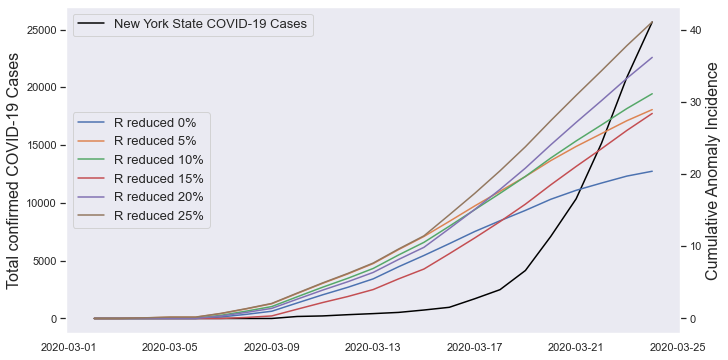

In [16]:
ny_input = bk_distancing[(bk_distancing.ds >= ny_covid.ds.min()) &
                         (bk_distancing.ds <= ny_covid.ds.max())]
fig, ax1 = plt.subplots(figsize=(11, 6))

ax2 = ax1.twinx()
for distancing in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    sub = ny_input[ny_input.distancing == (1 - distancing)].copy()
    sub['cumulative_anom'] = sub['anomaly_diff'].cumsum()
    sub.sort_values('ds', inplace=True)
    ax2.plot(sub.ds, sub.cumulative_anom,
             label=f'R reduced {round((1 - distancing)*100)}%')
ax1.plot(ny_covid.ds, ny_covid.cases, color='black', label='New York State COVID-19 Cases')

ax1.set_xlabel('')
ax1.set_ylabel('Total confirmed COVID-19 Cases', fontsize=16)
ax2.set_ylabel('Cumulative Anomaly Incidence', fontsize=16)
ax1.grid(False)
ax2.grid(False)
ax1.legend(fontsize=13)
ax2.legend(loc='center left', fontsize=13)

In [ ]:
# Now, let's look at how the correlations between cumulative anomaly incidence
# and total COVID cases vary with distancing reductions in transmission
# look at reductions down to 25% below standard

dfs = []

for distance in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    print(f'Running distancing at {distance}')
    out = run_anomalies(sc_df, ['2020-03-01'], social_mod=distance, simulations=10)
    out['distancing'] = 1 - distance
    dfs.append(out)
    
sc_distancing = pd.concat(dfs, axis=0)

Running distancing at 1
Forecasting for 6085


/Users/samchamberlain/.local/share/virtualenvs/therm_anomaly_detection-cYEoWQk6/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Running distancing at 0.95
Forecasting for 6085
Running distancing at 0.9
Forecasting for 6085


In [ ]:
sc_input = sc_distancing[(sc_distancing.ds >= sc_covid.ds.min()) &
                         (sc_distancing.ds <= sc_covid.ds.max())]

fig, ax1 = plt.subplots(figsize=(11, 6))
ax2 = ax1.twinx()
for distancing in [1, 0.95, 0.90, 0.85, 0.80, 0.75]:
    sub = sc_input[sc_input.distancing == (1 - distancing)].copy()
    sub['cumulative_anom'] = sub['anomaly_diff'].cumsum()
    sub.sort_values('ds', inplace=True)
    ax2.plot(sub.ds, sub.cumulative_anom,
             label=f'R reduced {round((1 - distancing)*100)}%')
ax1.plot(sc_covid.ds, sc_covid.cases, color='black', label='Santa Clara COVID-19 Cases')

ax1.set_xlabel('')
ax1.set_ylabel('Total confirmed COVID-19 Cases', fontsize=16)
ax2.set_ylabel('Cumulative Anomaly Incidence', fontsize=16)
ax1.grid(False)
ax2.grid(False)
ax1.legend(fontsize=13)
ax2.legend(loc='center left', fontsize=13)